In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import ParameterGrid

In [ ]:
csv_url = 'https://drive.google.com/uc?export=download&id=1H82PVxZHJJUOiUShGWZzXK_VoB8-XKy7'
train_data = pd.read_csv(csv_url)
train_data.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [ ]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

X = train_data.drop('Weekly_Sales', axis=1)

y = train_data['Weekly_Sales']


In [ ]:
X

,Store,Dept,Date,IsHoliday
0,1,1,2010-02-05,False
1,1,1,2010-02-12,True
2,1,1,2010-02-19,False
3,1,1,2010-02-26,False
4,1,1,2010-03-05,False
...,...,...,...,...
421565,45,98,2012-09-28,False
421566,45,98,2012-10-05,False
421567,45,98,2012-10-12,False
421568,45,98,2012-10-19,False


In [ ]:
y

,Weekly_Sales
0,24924.50
1,46039.49
2,41595.55
3,19403.54
4,21827.90
...,...
421565,508.37
421566,628.10
421567,1061.02
421568,760.01


In [ ]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
X = train_data.drop('Weekly_Sales', axis=1)
y = train_data['Weekly_Sales']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=123)

## Load the test data and pop the id column

In [ ]:
csv_url = 'https://drive.google.com/uc?export=download&id=1c8xCdpp48b54qzxUZmJf5mw9qcktdVD1'
test_data = pd.read_csv(csv_url)
test_data.head()


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [ ]:
test_data

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [ ]:
train_csv_url = 'https://drive.google.com/uc?export=download&id=1H82PVxZHJJUOiUShGWZzXK_VoB8-XKy7'
train_data = pd.read_csv(train_csv_url)

train_data['Date'] = pd.to_datetime(train_data['Date'])

X = train_data.drop('Weekly_Sales', axis=1)
y = train_data['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

test_csv_url = 'https://drive.google.com/uc?export=download&id=1c8xCdpp48b54qzxUZmJf5mw9qcktdVD1'
test_data = pd.read_csv(test_csv_url)
test_data['Date'] = pd.to_datetime(test_data['Date'])

def feature_engineering(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsHoliday'] = df['IsHoliday'].astype(int)
    return df.drop(columns=['Date'])  # Drop the 'Date' column after extracting features

X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)
test_data_features = feature_engineering(test_data)

preprocessor = make_column_transformer(
    (OrdinalEncoder(), ['Store', 'Dept']),
    (StandardScaler(), ['Year', 'Month', 'Week', 'DayOfWeek']),
    remainder='passthrough'
)

X_train_transformed = preprocessor.fit_transform(X_train)

X_train_split, X_valid, y_train_split, y_valid = train_test_split(
    X_train_transformed, y_train, test_size=0.2, random_state=123
)

model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=123)
model.fit(X_train_split, y_train_split)

X_test_transformed = preprocessor.transform(test_data_features)

test_data['Predicted_Weekly_Sales'] = model.predict(X_test_transformed)

test_data[['Store', 'Dept', 'Date', 'Predicted_Weekly_Sales']].to_csv('weekly_sales_predictions.csv', index=False)

print("Predictions saved to 'weekly_sales_predictions.csv'")


Predictions saved to 'weekly_sales_predictions.csv'


In [ ]:
X_train

,Store,Dept,IsHoliday,Year,Month,Week,DayOfWeek
277233,29,1,0,2012,10,41,4
54699,6,46,0,2010,4,15,4
377655,40,56,0,2012,6,22,4
63396,7,33,0,2012,1,3,4
5876,1,45,0,2011,5,20,4
...,...,...,...,...,...,...,...
192476,20,38,0,2011,6,23,4
17730,2,71,0,2010,6,24,4
28030,3,81,0,2010,9,35,4
277869,29,6,0,2011,4,14,4


In [ ]:
y_train

,Weekly_Sales
277233,15582.01
54699,27862.13
377655,16394.55
63396,2021.48
5876,10.47
...,...
192476,108255.91
17730,4129.97
28030,1052.81
277869,1616.97


In [ ]:
X_test

,Store,Dept,IsHoliday,Year,Month,Week,DayOfWeek
7678,1,72,1,2010,9,36,4
152194,16,31,0,2011,6,25,4
139533,15,10,0,2012,7,27,4
129743,14,12,0,2011,10,43,4
131316,14,24,0,2012,3,12,4
...,...,...,...,...,...,...,...
212813,22,45,0,2011,4,14,4
135596,14,71,0,2012,4,17,4
138726,15,5,0,2010,10,39,4
256718,26,98,0,2012,10,43,4


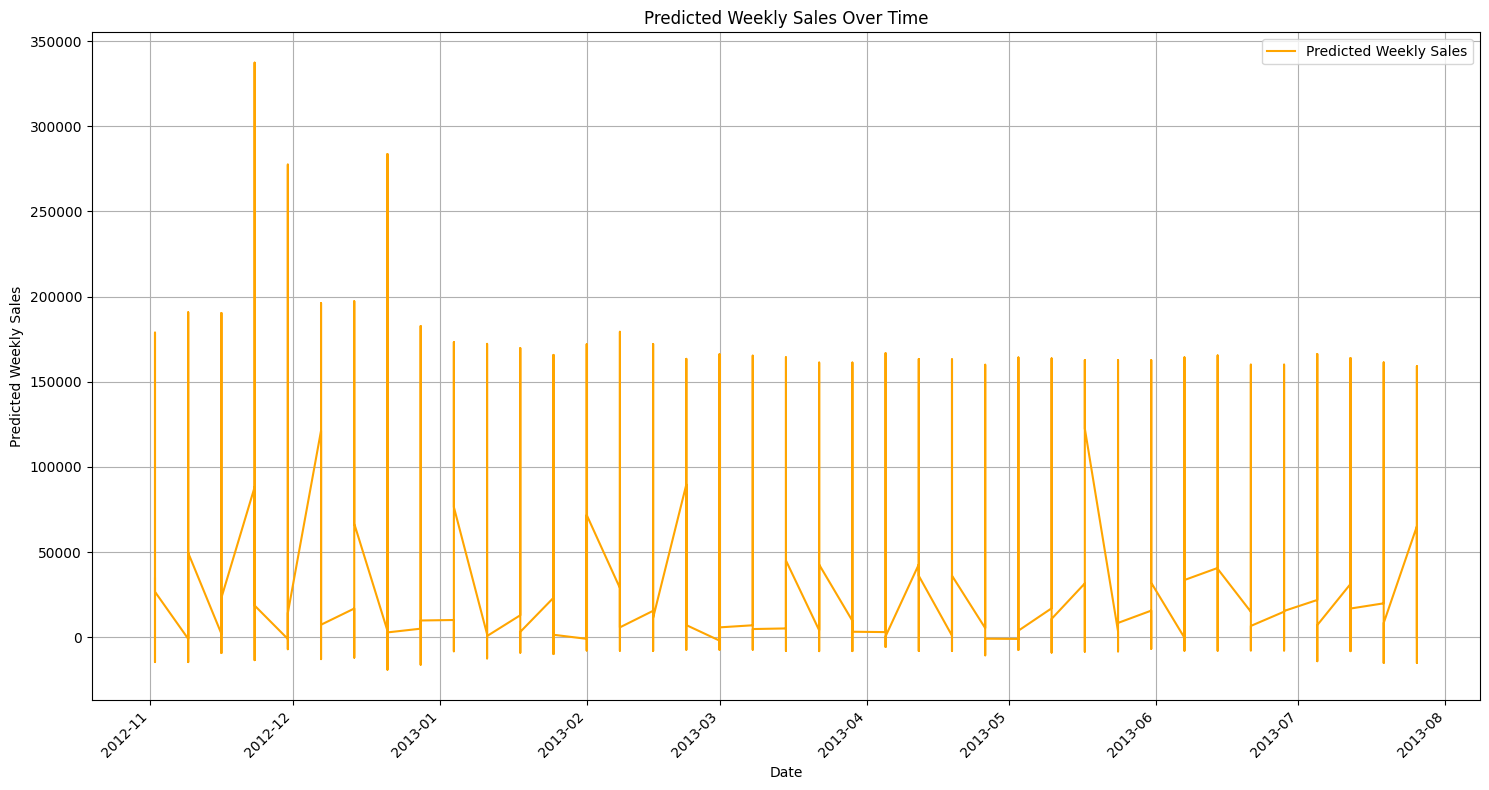

In [ ]:
test_data = test_data.sort_values('Date')

plt.figure(figsize=(15, 8))
plt.plot(test_data['Date'], test_data['Predicted_Weekly_Sales'], label='Predicted Weekly Sales', color='orange')
plt.title('Predicted Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Predicted Weekly Sales')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


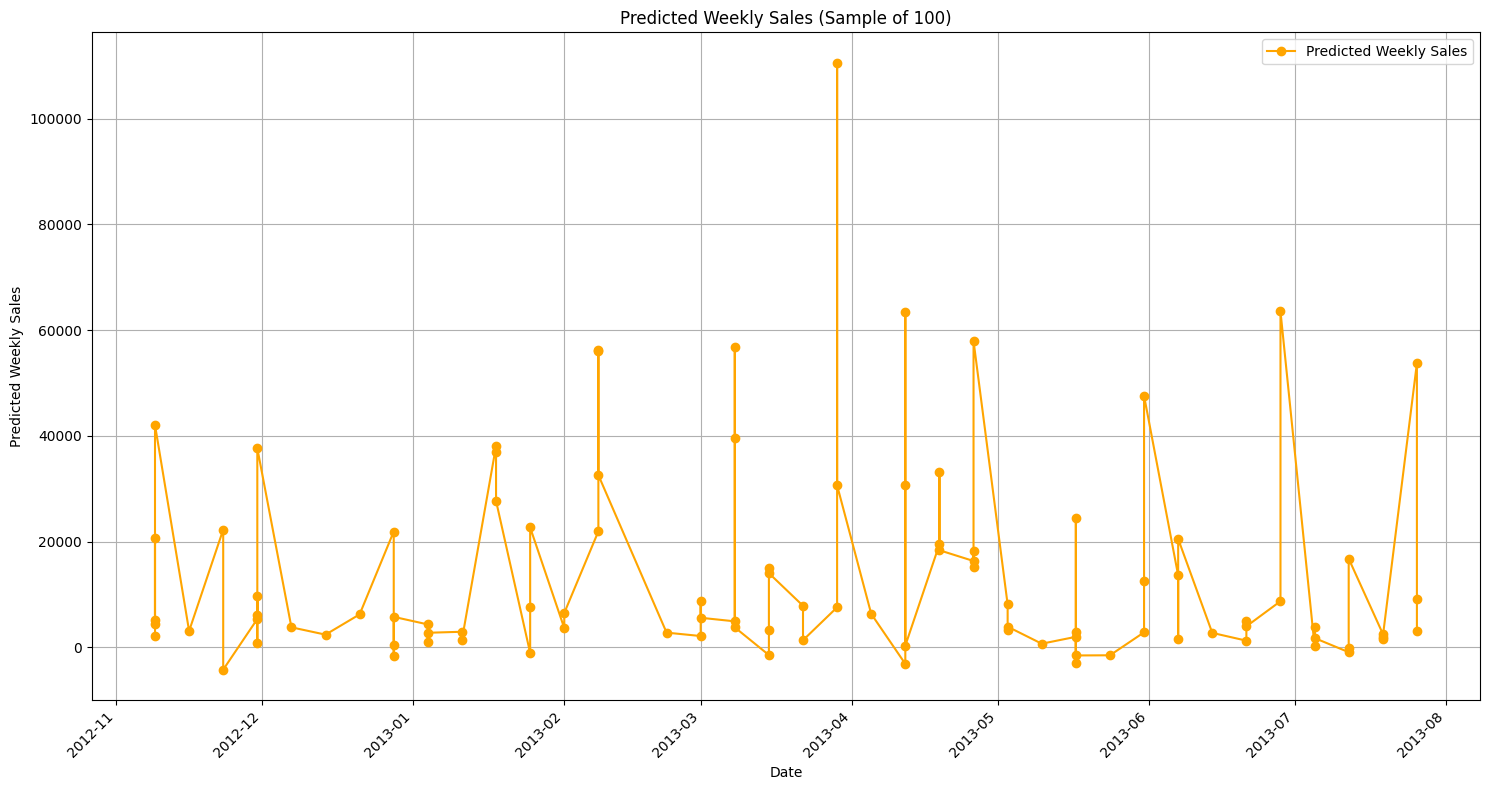

In [ ]:
sample = test_data.sample(n=100, random_state=123).sort_values('Date')

plt.figure(figsize=(15, 8))
plt.plot(sample['Date'], sample['Predicted_Weekly_Sales'], marker='o', label='Predicted Weekly Sales', color='orange')
plt.title('Predicted Weekly Sales (Sample of 100)')
plt.xlabel('Date')
plt.ylabel('Predicted Weekly Sales')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


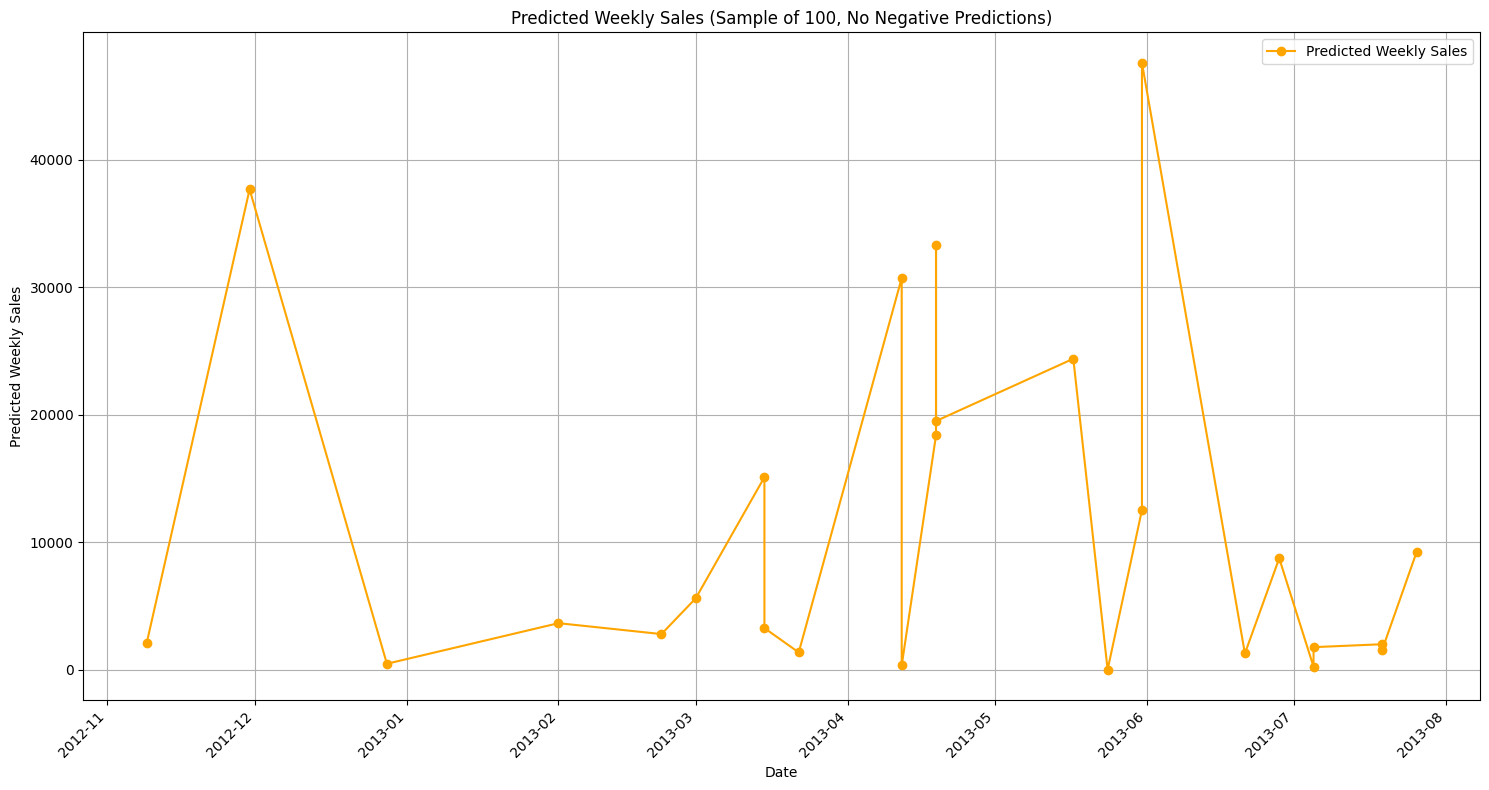

In [ ]:
test_data['Predicted_Weekly_Sales'] = test_data['Predicted_Weekly_Sales'].apply(lambda x: max(x, 0))

sample = test_data.sample(n=25, random_state=123).sort_values('Date')

plt.figure(figsize=(15, 8))
plt.plot(sample['Date'], sample['Predicted_Weekly_Sales'], marker='o', label='Predicted Weekly Sales', color='orange')
plt.title('Predicted Weekly Sales (Sample of 100, No Negative Predictions)')
plt.xlabel('Date')
plt.ylabel('Predicted Weekly Sales')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
test_data['Predicted_Weekly_Sales'] = test_data['Predicted_Weekly_Sales'].apply(lambda x: max(x, 0))

predictions_trends = test_data.groupby('Date')['Predicted_Weekly_Sales'].sum()

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=predictions_trends.index,
        y=predictions_trends.values,
        mode='lines',
        name='Predicted Weekly Sales',
        line=dict(color='orange')
    )
)

fig.update_layout(
    title="Predicted Weekly Sales Over Time",
    xaxis_title="Date",
    yaxis_title="Predicted Weekly Sales ($)",
    template="plotly_dark",
    xaxis_rangeslider_visible=True,
)


fig.show()
